In [1]:
!pip install transformers datasets torch torchvision pillow tqdm evaluate rouge_score

  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 3.5 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=3db87268441023e8a985726b8853f413fa60506fcccae6804af235b6b1b28dfa
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [2]:
import os
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer
from datasets import load_dataset, DatasetDict
from PIL import Image
from torchvision.transforms import ToTensor
import evaluate
from torch.utils.data import DataLoader
import numpy as np

In [20]:
# -------------------------------
# Configuration Parameters
# -------------------------------
DATASET_NAME = "tomytjandra/h-and-m-fashion-caption-12k"  # Replace with your dataset name or path
MODEL_NAME = "Salesforce/blip-image-captioning-base"  # Pre-trained BLIP model
OUTPUT_DIR = "./blip-finetuned"  # Directory to save the fine-tuned model
BATCH_SIZE = 32  # Adjust based on your GPU memory
EPOCHS = 3
LEARNING_RATE = 5e-5
MAX_LENGTH = 224  # Maximum length of generated captions
SEED = 42
USE_GPU = torch.cuda.is_available()
TEST_SPLIT_PERCENTAGE = 20

torch.manual_seed(SEED)
if USE_GPU:
    torch.cuda.manual_seed_all(SEED)

In [ ]:
# -------------------------------
# Load the Dataset
# -------------------------------
# Replace 'your_dataset_name' with your actual dataset name or local path
dataset = load_dataset(DATASET_NAME)

# -------------------------------
# Load BLIP Model and Processor
# -------------------------------
processor = BlipProcessor.from_pretrained(MODEL_NAME)
model = BlipForConditionalGeneration.from_pretrained(MODEL_NAME)

# Move model to GPU if available
device = torch.device("cuda" if USE_GPU else "cpu")
model.to(device)

(array([ 285., 1042., 1949., 2292., 2256., 1939., 1560.,  891.,  206.,
          17.]),
 array([ 60. ,  83.4, 106.8, 130.2, 153.6, 177. , 200.4, 223.8, 247.2,
        270.6, 294. ]),
 <BarContainer object of 10 artists>)

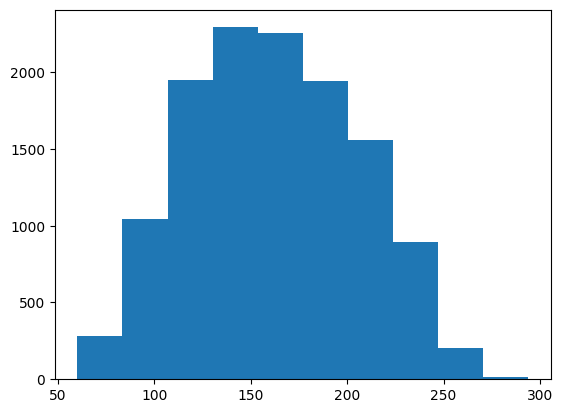

In [15]:
import matplotlib.pyplot as plt

check = []
for cp in dataset['train']['text']:
  check.append(len(cp))

plt.hist(check, bins = 10)

In [13]:
max(check)

294

In [17]:
def preprocess_function(examples):
    # Process images
    images = []
    for img in examples['image']:
        images.append(img.convert("RGB"))

    # Tokenize captions
    inputs = processor(images=images, text=examples['text'],
                      max_length=MAX_LENGTH, padding="max_length", truncation=True)
    return inputs

In [ ]:
split_dataset = dataset['train'].train_test_split(test_size=TEST_SPLIT_PERCENTAGE / 100, seed=42)
print("\nSplit Dataset Structure:")
print(split_dataset)

# Assign splits
train_dataset = split_dataset['train']
test_dataset = split_dataset['test']

# -------------------------------
# Apply Preprocessing to Dataset
# -------------------------------
print("\nPreprocessing the training data...")
tokenized_train = train_dataset.map(preprocess_function, batched=True, batch_size = BATCH_SIZE)


Split Dataset Structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'image'],
        num_rows: 9949
    })
    test: Dataset({
        features: ['text', 'image'],
        num_rows: 2488
    })
})

Preprocessing the training data...


Map:   0%|          | 0/9949 [00:00<?, ? examples/s]